In [1]:
import pandas as pd
from scipy.io import arff
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from random import randint, random
import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import log_loss
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score

In [7]:
column_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class','difficulty']

In [8]:
class_dict = {'DOS':0, 'R2L':1, 'PROBE':2, 'U2R':3, 'NORMAL':4}  # custom labels hard coded

# Reaing and Preprocessing
def read():
    train = pd.read_csv(r'../../Datasets/NSL_KDD/KDDTrain+.txt', sep=',',header = None, names = column_names) 
    train.drop(['difficulty'],axis=1,inplace=True)
    change_label(train)
    train_x = train[train.columns[:-1]]
    normalization(train_x)
    train_x = one_hot(train_x)
    train_y = train[train.columns[-1]]
    
    test = pd.read_csv(r'../../Datasets/NSL_KDD/KDDTest+.txt', sep=',',header = None, names = column_names)
    test.drop(['difficulty'],axis=1,inplace=True)
    change_label(test)
    test_x = test[test.columns[:-1]]
    normalization(test_x)
    test_x = one_hot(test_x)
    test_y = test[test.columns[-1]]
    
    total_columns = list(set(train_x).union(set(test_x)))
    total_columns.sort() 
    for j in set(total_columns)-set(train_x):
        train_x[j] = 0.0
    for j in set(total_columns)-set(test_x):
        test_x[j] = 0.0
    train_x = train_x[total_columns]
    test_x = test_x[total_columns]
    
    return train_x,train_y,test_x,test_y

def change_label(df): # 5-classes including normal
    df['class'].replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm',
                         'worm'],'DOS',inplace=True)
    df['class'].replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail',
       'snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
    df['class'].replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'PROBE',inplace=True)
    df['class'].replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)
    df['class'].replace(['normal'],'NORMAL',inplace=True)
    df['class'] = [class_dict[i] for i in df['class']]
    
def one_hot(df): # 3 categorical variables
    category_columns = ['protocol_type','service','flag']
    categorical = df[category_columns]
    categorical = pd.get_dummies(categorical,columns = category_columns)
    df = pd.concat([df, categorical], axis=1, join='inner')
    df = df[list(set(df.columns) - set(category_columns))]
    return df
    
def normalization(df):
    std_scaler = StandardScaler()
    numeric_col = df.select_dtypes(include='float').columns
    df[numeric_col] = StandardScaler().fit_transform(df[numeric_col])
    print("finished")

In [9]:
train_x, train_y, x_test, y_test = read()

/data/kmohan/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


finished
finished


/data/kmohan/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [10]:
train_x.head()

,count,diff_srv_rate,dst_bytes,dst_host_count,dst_host_diff_srv_rate,dst_host_rerror_rate,dst_host_same_src_port_rate,dst_host_same_srv_rate,dst_host_serror_rate,dst_host_srv_count,...,service_vmnet,service_whois,src_bytes,srv_count,srv_diff_host_rate,srv_rerror_rate,srv_serror_rate,su_attempted,urgent,wrong_fragment
0,2,-0.349683,0,150,-0.280282,-0.224532,0.069972,-0.782367,-0.639532,25,...,0,0,491,2,-0.374560,-0.374432,-0.631929,0,0,0
1,13,0.482201,0,255,2.736852,-0.387635,2.367737,-1.161030,-0.639532,1,...,0,0,146,1,-0.374560,-0.374432,-0.631929,0,0,0
2,123,0.038529,0,255,-0.174417,-0.387635,-0.480197,-0.938287,1.608759,26,...,0,0,0,6,-0.374560,-0.374432,1.605104,0,0,0
3,5,-0.349683,8153,30,-0.439078,-0.387635,-0.383108,1.066401,-0.572083,255,...,0,0,232,5,-0.374560,-0.374432,-0.184522,0,0,0
4,30,-0.349683,420,255,-0.439078,-0.387635,-0.480197,1.066401,-0.639532,255,...,0,0,199,32,-0.028179,-0.374432,-0.631929,0,0,0


# Random Forest Classifier

In [11]:
feature_names = [f"feature {i}" for i in range(train_x.to_numpy().shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(train_x.to_numpy(), train_y.to_numpy())

RandomForestClassifier(random_state=0)

In [ ]:
y_pred = clf.predict(x_test)
print(clf.score(y_pred, y_test, sample_weight=None))

In [ ]:
print(f1_score(y_test, y_pred, average='macro'))
print(accuracy_score(y_test, y_pred))

In [ ]:
precision = precision_score(y_test, y_pred, average='macro')
print('Precision: %.3f' % precision)

recall = recall_score(y_test, y_pred, average='macro')
print('Recall: %.3f' % recall)

In [12]:
start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.027 seconds


In [13]:
importances


array([5.40558132e-02, 6.06812353e-02, 6.62913338e-02, 2.01897076e-02,
       4.56368222e-02, 1.34117697e-02, 3.26631625e-02, 2.48202176e-02,
       4.45376811e-02, 3.37534429e-02, 1.61936255e-02, 9.10897728e-03,
       4.92880345e-02, 3.53377805e-03, 3.43136903e-05, 2.84278602e-03,
       5.89608573e-04, 1.23307612e-04, 3.36869008e-03, 2.07159382e-02,
       1.46783822e-04, 6.13638945e-05, 1.07686806e-05, 6.33484535e-02,
       4.69097528e-04, 6.71551768e-03, 9.40449648e-04, 0.00000000e+00,
       3.57884676e-05, 1.99510182e-02, 6.69975042e-05, 5.39089975e-03,
       2.14024928e-04, 1.28422950e-04, 0.00000000e+00, 2.50563515e-04,
       4.38835459e-05, 1.70393943e-02, 9.78938848e-03, 5.69678570e-03,
       1.45488894e-02, 1.23240448e-04, 7.39264153e-02, 1.87375143e-02,
       1.57320638e-04, 4.24224437e-05, 5.64007046e-06, 0.00000000e+00,
       7.39023287e-05, 3.34870423e-06, 8.30678010e-07, 7.85613917e-07,
       6.90571827e-06, 3.86096620e-06, 5.05862354e-06, 2.08273233e-05,
      

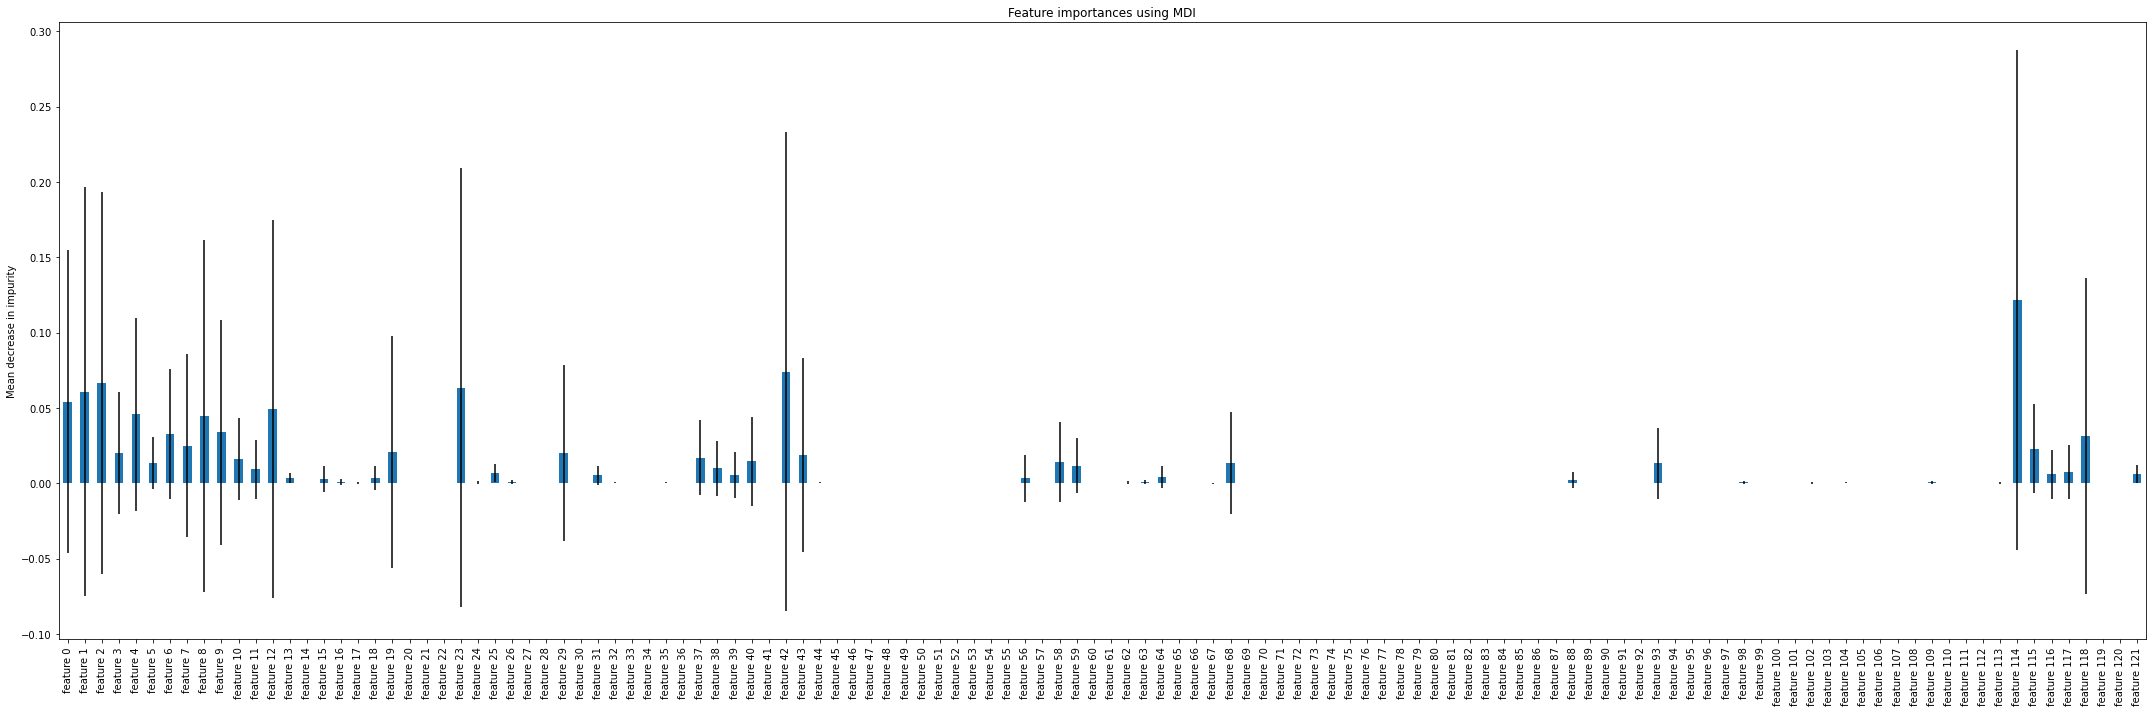

In [14]:
forest_importances = pd.Series(importances, index=feature_names)

plt.rcParams["figure.figsize"] = (30,10)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Naive Bayes

In [15]:
from sklearn.naive_bayes import GaussianNB

In [16]:
gnb = GaussianNB()

In [17]:
y_pred = forest.predict(x_test)
y_pred.shape

(22544,)

In [18]:
print(f1_score(y_test, y_pred,average='micro'))
print(accuracy_score(y_test, y_pred))

0.5978530872959545
0.5978530872959545


# KNN

In [19]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

In [20]:
knn.fit(train_x, train_y)
y_pred = knn.predict(x_test)
y_pred.shape

(22544,)

In [21]:
print(f1_score(y_test, y_pred,average='micro'))
print(accuracy_score(y_test, y_pred))

0.7334102200141943
0.7334102200141944


# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics  import accuracy_score,f1_score

In [ ]:
clf2 = DecisionTreeClassifier(random_state=0)

clf2.fit(train_x, train_y)

In [ ]:
y_pred = clf2.predict(x_test)
print(accuracy_score(y_test, y_pred))

In [ ]:
f1_score(y_test,y_pred,average='macro')
print(f1_score)

In [ ]:
precision = precision_score(y_test, y_pred, average='macro')#, pos_label=0)
print('Precision: %.3f' % precision)

In [ ]:
recall = recall_score(y_test, y_pred, average='macro')#, pos_label=0)
print('Recall: %.3f' % recall)

# PCA


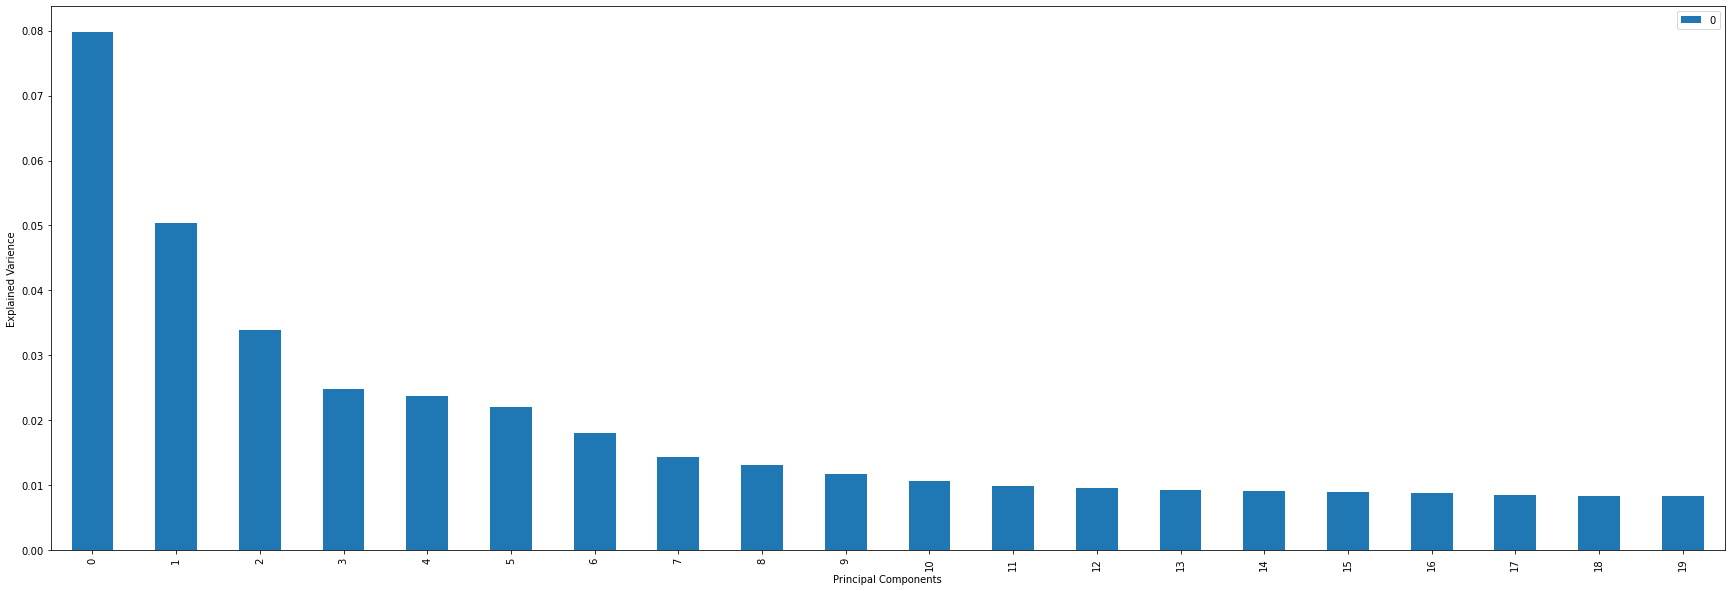

In [25]:
train_X = train_x
test_X = test_x

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_X = sc.fit_transform(train_X)
test_X = sc.transform(test_X)

from sklearn.decomposition import PCA
pca = PCA(n_components=20)
train_X = pca.fit_transform(train_X)
test_X = pca.transform(test_X)

explained_variance = pca.explained_variance_ratio_

import matplotlib.pyplot as plt
pd.DataFrame(pca.explained_variance_ratio_).plot.bar()
plt.xlabel('Principal Components')
plt.ylabel('Explained Varience')
plt.xticks(rotation=90)
plt.rcParams["figure.figsize"] = (10,20)
plt.show()

In [26]:
train_x

,count,diff_srv_rate,dst_bytes,dst_host_count,dst_host_diff_srv_rate,dst_host_rerror_rate,dst_host_same_src_port_rate,dst_host_same_srv_rate,dst_host_serror_rate,dst_host_srv_count,...,service_vmnet,service_whois,src_bytes,srv_count,srv_diff_host_rate,srv_rerror_rate,srv_serror_rate,su_attempted,urgent,wrong_fragment
0,2,-0.349683,0,150,-0.280282,-0.224532,0.069972,-0.782367,-0.639532,25,...,0,0,491,2,-0.374560,-0.374432,-0.631929,0,0,0
1,13,0.482201,0,255,2.736852,-0.387635,2.367737,-1.161030,-0.639532,1,...,0,0,146,1,-0.374560,-0.374432,-0.631929,0,0,0
2,123,0.038529,0,255,-0.174417,-0.387635,-0.480197,-0.938287,1.608759,26,...,0,0,0,6,-0.374560,-0.374432,1.605104,0,0,0
3,5,-0.349683,8153,30,-0.439078,-0.387635,-0.383108,1.066401,-0.572083,255,...,0,0,232,5,-0.374560,-0.374432,-0.184522,0,0,0
4,30,-0.349683,420,255,-0.439078,-0.387635,-0.480197,1.066401,-0.639532,255,...,0,0,199,32,-0.028179,-0.374432,-0.631929,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,184,-0.016930,0,255,-0.121485,-0.387635,-0.480197,-0.938287,1.608759,25,...,0,0,0,25,-0.374560,-0.374432,1.605104,0,0,0
125969,2,-0.349683,145,255,-0.386146,-0.387635,-0.447834,0.977304,-0.639532,244,...,0,0,105,2,-0.374560,-0.374432,-0.631929,0,0,0
125970,1,-0.349683,384,255,-0.121485,-0.355014,-0.480197,-0.893738,0.979238,30,...,0,0,2231,1,-0.374560,-0.374432,-0.631929,0,0,0
125971,144,-0.072389,0,255,-0.174417,-0.387635,-0.480197,-1.094207,1.608759,8,...,0,0,0,8,-0.374560,-0.374432,1.605104,0,0,0
